<a href="https://colab.research.google.com/github/lstamaria/codelab_practice/blob/master/Phuket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Upload the scraping result/json file to colab (not needed if done locally in jupyter notebook)


In [0]:
from google.colab import files
uploaded = files.upload()

Saving result.json to result (1).json


Load to dataframe

In [0]:
import pandas as pd
import json

file = 'result.json'
with open(file) as data_file:
  js = json.load(data_file)
  df = pd.DataFrame(js)


Parse ameneties into separate columns and create a dataframe which has 0 or 1 for each amenity.

In [0]:
df.head(3)

,a,d,rank,rating,rb,review
0,"[Pool, Room service, Free parking, Restaurant,...","{""@context"":""http://schema.org"",""@type"":""Lodgi...",#6 of 366 hotels in Phuket,4.5,"{'Location': 'bubble_40', 'Cleanliness': 'bubb...","1,039 reviews"
1,"[Free High Speed Internet (WiFi), Pool, Free p...","{""@context"":""http://schema.org"",""@type"":""Lodgi...",#37 of 366 hotels in Phuket,4.5,"{'Location': 'bubble_45', 'Cleanliness': 'bubb...","1,864 reviews"
2,"[Room service, Pool, Restaurant, Fitness Cente...","{""@context"":""http://schema.org"",""@type"":""Lodgi...",#13 of 41 hotels in Phuket,4.5,"{'Location': 'bubble_45', 'Cleanliness': 'bubb...","2,332 reviews"


In [0]:
def parse_amenities(row):
  amenities_list = row['a']
  am_map = {}
  for am in amenities_list:
    am_map[am] = 1
  return am_map


amenities_df = df.apply(parse_amenities, result_type='expand', axis=1)

In [0]:
amenities_df.fillna(value=0, inplace=True)

Parse other data out of the dataframe's d column which is a nested json

In [0]:
import re

def parse_d(row):
  data = row['d'] # data is a string
  data_js = json.loads(data)  # data_js is a json
  # Extract name, rating, review, price_min, price_max and address-zipcode
  data_map = {}
  data_map['name'] = data_js['name']
  rating_data = data_js['aggregateRating']
  data_map['rating'] = rating_data['ratingValue']
  data_map['review'] = int(rating_data['reviewCount'])
  data_map['address'] = data_js['address']['postalCode']
  
  # Now price info
  if 'priceRange' in data_js:
    price_info = data_js['priceRange']
    data_map['price_info'] = price_info # Recording for debugging
    match = re.search('₱([0-9,]+) - ₱([0-9,]+)', price_info)
    if match:
      data_map['price_min'] = int(match.group(1).replace(',', ''))
      data_map['price_max'] = int(match.group(2).replace(',', ''))
    else:
      print('No price extracted out of ', price_info)  # Helps us check if we are parsing everything
  
  return data_map

d_df = df.apply(parse_d, result_type='expand', axis=1)

Parse rating breakdown (location, cleanliness etc) and ranking.


In [0]:
def parse_rest(row):
  ranking = row['rank']
  r_map = {}
  match = re.search('#([0-9]+) of 366 hotels in Phuket', ranking) # Make sure they all follow the same pattern
  if match:
    r_map['rank'] = int(match.group(1).replace(',', ''))
  else:
    print('ranking did not match for ', ranking)
  
  rb = row['rb']
  for key in rb:
    r_map[key] = rb[key][7:]
  
  return r_map


r_df = df.apply(parse_rest, result_type='expand', axis=1)
r_df[0:3]

ranking did not match for  #13 of 41 hotels in Phuket
ranking did not match for  #1 of 9 hotels in Phuket
ranking did not match for  #8 of 41 hotels in Phuket
ranking did not match for  #4 of 12 hotels in Phuket
ranking did not match for  #14 of 41 hotels in Phuket
ranking did not match for  #1 of 52 hotels in Phuket
ranking did not match for  #31 of 58 hotels in Phuket
ranking did not match for  #18 of 466 B&Bs / Inns in Phuket
ranking did not match for  #12 of 14 hotels in Phuket
ranking did not match for  #3 of 178 B&Bs / Inns in Phuket
ranking did not match for  #5 of 466 B&Bs / Inns in Phuket
ranking did not match for  #40 of 466 B&Bs / Inns in Phuket
ranking did not match for  #4 of 16 B&Bs / Inns in Phuket
ranking did not match for  #16 of 225 B&Bs / Inns in Phuket
ranking did not match for  #6 of 271 Specialty lodging in Phuket
ranking did not match for  #8 of 73 B&Bs / Inns in Phuket
ranking did not match for  #1 of 41 Specialty lodging in Phuket
ranking did not match for  #21

,Cleanliness,Location,Service,Value,rank
0,45,40,45,45,6.0
1,45,45,40,45,37.0
2,45,45,45,40,NaN


In [0]:
# Merge the interesting dataframes to start working

mdf = d_df.join(r_df.join(amenities_df, how='outer'), how='outer')

In [0]:
mdf[0:3]

,address,name,price_info,price_max,price_min,rating,review,Cleanliness,Location,Service,Value,rank,Accessible rooms,Air conditioning,Airport transportation,Babysitting,Banquet Room,Bar/Lounge,Breakfast Available,Breakfast included,Business Center with Internet Access,Children Activities (Kid / Family Friendly),Concierge,Conference Facilities,Dry Cleaning,Family Rooms,Fitness Center with Gym / Workout Room,Free High Speed Internet (WiFi),Free parking,Golf Course,Hot Tub,Kitchenette,Laundry Service,Meeting rooms,Microwave,Minibar,Multilingual Staff,Non-smoking hotel,Non-smoking rooms,Outdoor pool,Pool,Public Wifi,Refrigerator in room,Restaurant,Room service,Sauna,Self-Serve Laundry,Shuttle Bus Service,Smoking rooms available,Spa,Suites,Tennis Court,Wheelchair Access
0,83150,The Marina Phuket Hotel,"₱2,349 - ₱7,568 (Based on Average Rates for a ...",7568.0,2349.0,4.5,1041,45,40,45,45,6.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,83150,Holiday Inn Express Phuket Patong Beach Central,"₱3,184 - ₱5,898 (Based on Average Rates for a ...",5898.0,3184.0,4.5,1864,45,45,40,45,37.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,83110,Dusit Thani Laguna Phuket,"₱4,906 - ₱30,741 (Based on Average Rates for a...",30741.0,4906.0,4.5,2333,45,45,45,40,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0


**Our data is prepared now.**

Now we will start analyzing it. We will start with simplest things first to understand our data first.

# Analysis

Let me first create a bar graph of number of hotels in each zipcode.

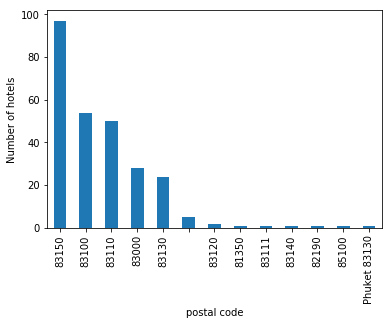

In [0]:
from matplotlib import pyplot as plt

plt.xlabel('postal code')
plt.ylabel('Number of hotels')
mdf['address'].value_counts().plot(kind='bar')

Phuket 83150 seems to be extremely popular. Let's check what these popular zipcodes map to in reality.

83150 happens to be Patong, the most popular beach in Phuket. 83100 is southern Phuket which includes Karon beach and many viewpoints while 83110 is nothern Phuket and includes the airport.


Next let me plot number of hotels w.r.t ratings.

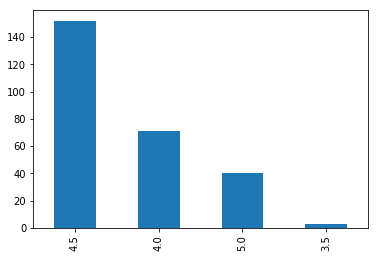

In [0]:
mdf['rating'].value_counts().plot(kind='bar')

Most hotels are 4.5 star rated (it could also be because of sampling, we have sampled from the top). Let us assume there is no sampling bias here, let us see if the distribution is any different in the top three locations.

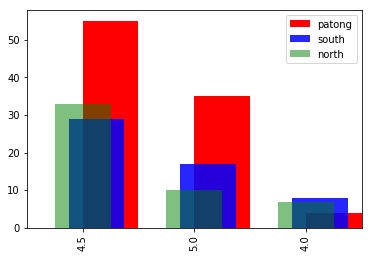

In [0]:
vc1 = mdf[mdf['address'] == '83150']['rating'].value_counts()
vc2 = mdf[mdf['address'] == '83100']['rating'].value_counts()
vc3 = mdf[mdf['address'] == '83110']['rating'].value_counts()
vc1.plot(kind='bar', color='red', label='patong', position=0, alpha=1.0)
vc2.plot(kind='bar', color='blue', label='south', position=0.25, alpha=0.85)
vc3.plot(kind='bar', color='green', label='north', position=0.5, alpha=0.5)
plt.legend()

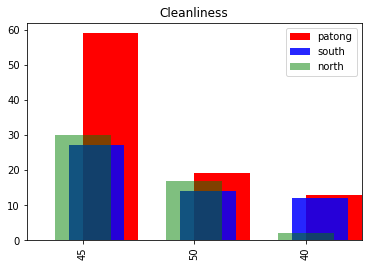

In [0]:
# Create the above to a function, so that I can look for other similar plots.

def plot3Locs(key):
  vc1 = mdf[mdf['address'] == '83150'][key].value_counts()
  vc2 = mdf[mdf['address'] == '83100'][key].value_counts()
  vc3 = mdf[mdf['address'] == '83110'][key].value_counts()
  vc1.plot(kind='bar', color='red', label='patong', position=0, alpha=1.0)
  vc2.plot(kind='bar', color='blue', label='south', position=0.25, alpha=0.85)
  vc3.plot(kind='bar', color='green', label='north', position=0.5, alpha=0.5)
  plt.title(key)
  plt.legend()

plot3Locs('Cleanliness')

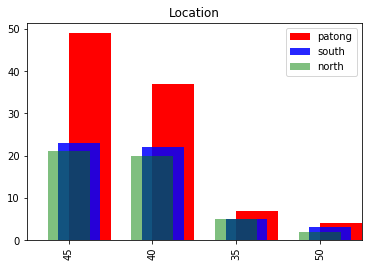

In [0]:
plot3Locs('Location')


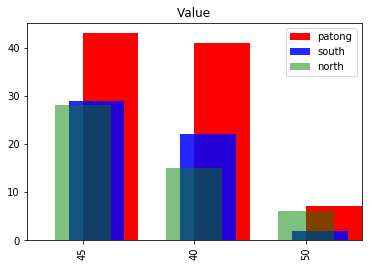

In [0]:
plot3Locs('Value')


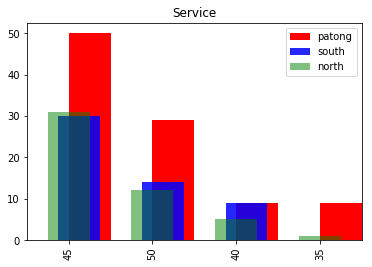

In [0]:
plot3Locs('Service')

In [0]:
# Does price depend on amenities

for key in amenities_df.columns.values:
  print(key, '\t', mdf['price_max'].corr(mdf[key]))

Accessible rooms 	 0.07343002536385473
Air conditioning 	 -0.01763045334058619
Airport transportation 	 -0.009700176449822276
Babysitting 	 0.08301258197222844
Banquet Room 	 0.046093566779459916
Bar/Lounge 	 -0.0022969825231890385
Breakfast Available 	 0.014170113585698144
Breakfast included 	 0.008616016178784883
Business Center with Internet Access 	 0.02430345699958081
Children Activities (Kid / Family Friendly) 	 0.07343002536385473
Concierge 	 0.001833298196485412
Conference Facilities 	 0.059293031027625606
Dry Cleaning 	 0.015419711596339506
Family Rooms 	 -0.00494702999644419
Fitness Center with Gym / Workout Room 	 0.027129807383013075
Free High Speed Internet (WiFi) 	 -0.026944555626064057
Free parking 	 0.01240964498674335
Golf Course 	 0.01390284423106898
Hot Tub 	 0.08220551292580064
Kitchenette 	 0.030591663299899662
Laundry Service 	 0.0028830032698712238
Meeting rooms 	 0.048873640909345636
Microwave 	 0.030591663299899662
Minibar 	 0.027741863241997344
Multilingual St

In [0]:
for key in amenities_df.columns.values:
  print(mdf[key].value_counts())

0.0    263
1.0      3
Name: Accessible rooms, dtype: int64
0.0    252
1.0     14
Name: Air conditioning, dtype: int64
0.0    253
1.0     13
Name: Airport transportation, dtype: int64
0.0    262
1.0      4
Name: Babysitting, dtype: int64
0.0    263
1.0      3
Name: Banquet Room, dtype: int64
0.0    256
1.0     10
Name: Bar/Lounge, dtype: int64
0.0    256
1.0     10
Name: Breakfast Available, dtype: int64
0.0    260
1.0      6
Name: Breakfast included, dtype: int64
0.0    263
1.0      3
Name: Business Center with Internet Access, dtype: int64
0.0    263
1.0      3
Name: Children Activities (Kid / Family Friendly), dtype: int64
0.0    254
1.0     12
Name: Concierge, dtype: int64
0.0    262
1.0      4
Name: Conference Facilities, dtype: int64
0.0    255
1.0     11
Name: Dry Cleaning, dtype: int64
0.0    258
1.0      8
Name: Family Rooms, dtype: int64
0.0    256
1.0     10
Name: Fitness Center with Gym / Workout Room, dtype: int64
0.0    253
1.0     13
Name: Free High Speed Internet (WiFi),

In [0]:
df['d'][17] # This hotel has amenities but somehow it is not there in our scraped data. We may need to scrape again/investigate. We can't do any analysis on amenities now because our data is unreliable.

'{"@context":"http://schema.org","@type":"LodgingBusiness","name":"Baan Oui","url":"/Hotel_Review-g1231757-d1637908-Reviews-Baan_Oui-Nai_Harn_Rawai_Phuket.html","image":"https://media-cdn.tripadvisor.com/media/photo-s/02/06/9c/bc/nai-harn-beach.jpg","priceRange":"₱887 - ₱1,931 (Based on Average Rates for a Standard Room)","aggregateRating":{"@type":"AggregateRating","ratingValue":"4.5","reviewCount":"62"},"address":{"@type":"PostalAddress","streetAddress":"14/95-96 Moo 1.Saiyuan Road Tambol Rawai","addressLocality":"Nai Harn","addressRegion":"","postalCode":"83130","addressCountry":{"@type":"Country","name":"Thailand"}}}'

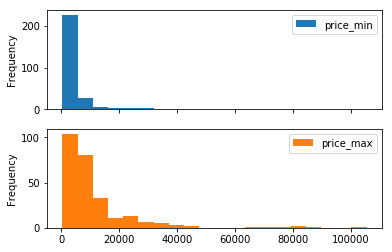

In [0]:
# Does rating influence pricing.
# Since there are only three rating buckets that we have, we will have to look at the three sets separately.

ax = mdf[['price_min', 'price_max']].plot.hist(bins=20, subplots=True)


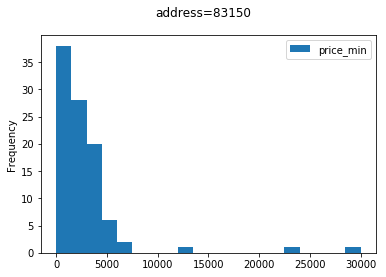

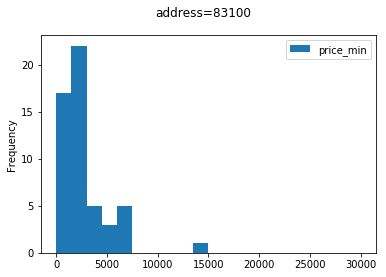

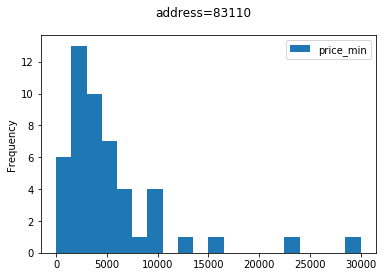

In [0]:
def plotPriceWRT(key, values, col):
  for val in values:
    mdf[mdf[key] == val][col].plot.hist(bins=20,
                                        subplots=True,
                                        title=key + '=' + val,
                                        range=(0, 30000))
    
plotPriceWRT('address', ['83150', '83100', '83110'], ['price_min'])

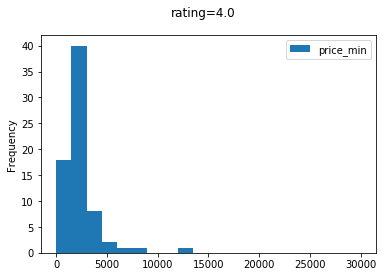

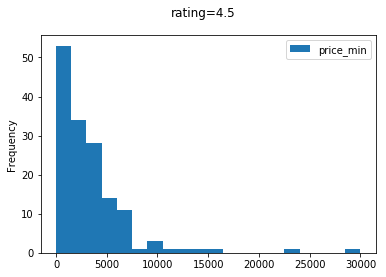

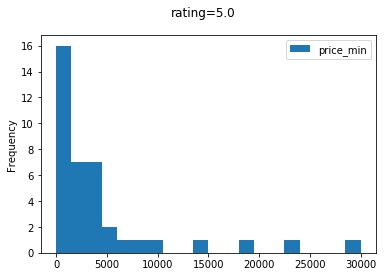

In [0]:
plotPriceWRT('rating', ['4.0', '4.5', '5.0'], ['price_min'])

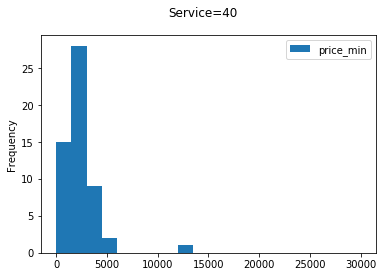

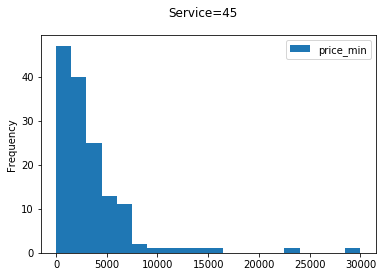

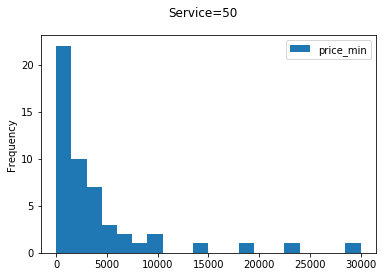

In [0]:
# Do people pay for service?

plotPriceWRT('Service', ['40', '45', '50'], ['price_min'])

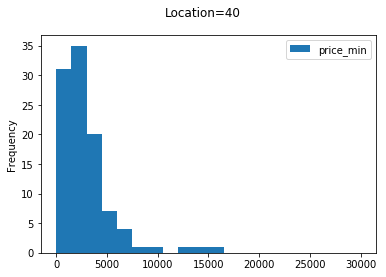

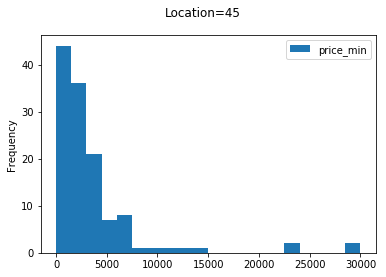

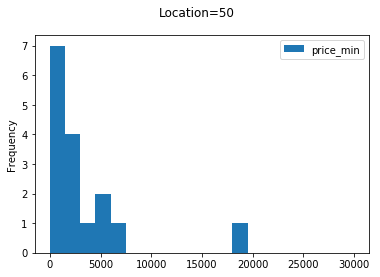

In [0]:
# Do people pay for Location?

plotPriceWRT('Location', ['40', '45', '50'], ['price_min'])

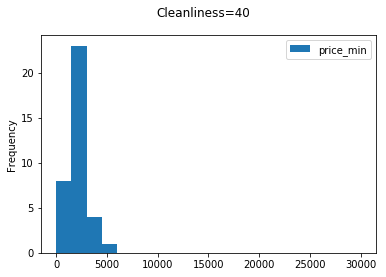

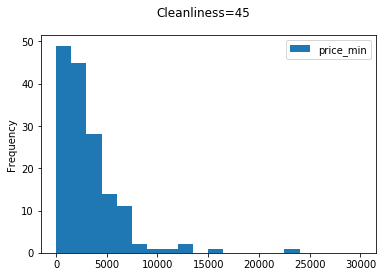

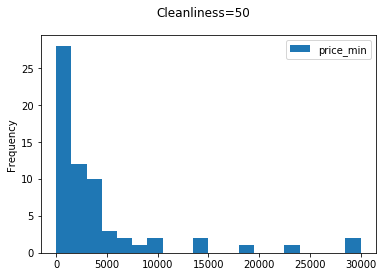

In [0]:
# Do people pay for Cleanliness?

plotPriceWRT('Cleanliness', ['40', '45', '50'], ['price_min'])

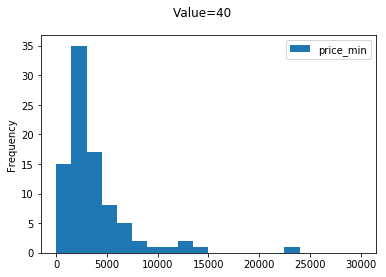

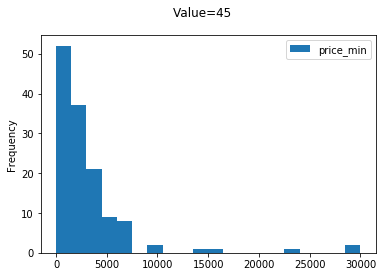

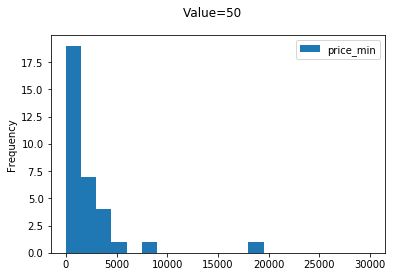

In [0]:
# Are cheaper hotel 'value'd?

plotPriceWRT('Value', ['40', '45', '50'], ['price_min'])

In [0]:
# Do cleaner hotels get more reviews?
# It would be expected that hotels with very high level of cleanliness and very
# low level of cleanliness will be reviewed more than the others i.e. on a per
# visitor basis. On the other hand hotels with less clean rooms would get less
# visitors. So the effect may not be as pronounced for non-clean hotels.

# We will look at median number of reviews

def printMedian(key, values):
  print(key, '--')
  for val in values:
    print(val, ' has #rev ', mdf[mdf[key] == val]['review'].median())

printMedian('Cleanliness', ['35', '40', '45', '50'])


Cleanliness --
35  has #rev  901.5
40  has #rev  834.0
45  has #rev  492.0
50  has #rev  164.0


In [0]:
# Hypothesis does not hold true. It looks like people review more when they are unhappy.
# Is that true?

printMedian('rating', ['3.5', '4.0', '4.5', '5.0'])

rating --
3.5  has #rev  922.0
4.0  has #rev  773.0
4.5  has #rev  434.5
5.0  has #rev  161.0


In [0]:
# It definitely seems true now. #Reviews would be a bad indicator of demand.
# Let's check a little more.

printMedian('Service', ['35', '40', '45', '50'])
printMedian('Location', ['35', '40', '45', '50'])
printMedian('Value', ['35', '40', '45', '50'])

Service --
35  has #rev  926.5
40  has #rev  767.0
45  has #rev  443.0
50  has #rev  164.0
Location --
35  has #rev  666.5
40  has #rev  692.5
45  has #rev  343.0
50  has #rev  154.0
Value --
35  has #rev  832.0
40  has #rev  965.0
45  has #rev  275.0
50  has #rev  113.0


People seem more tolerant of bad location as far as tendency to write a review is concerned.

In [0]:
# Could there be a connection between #reviews and pricing?
# From what we discovered we should not club differently rated hotels together.
# But first let's see if there is any correlation between overall rating and other
# ratings.

def toFloat(row):
  return float(row)

def printCorr(key, keys):
  for sk in keys:
    print('Correlation between ', key, ' and ', sk, '\t',
          mdf[key].apply(toFloat).corr(mdf[sk].apply(toFloat)))

printCorr('rating', ['Cleanliness', 'Service', 'Location', 'Value'])


Correlation between  rating  and  Cleanliness 	 0.6901304389963504
Correlation between  rating  and  Service 	 0.7808058250549523
Correlation between  rating  and  Location 	 0.3155174456537072
Correlation between  rating  and  Value 	 0.6703000683374944


In [0]:
def printFilteredCorr(filter_key, filter_value, key, keys):
  f_df = mdf[mdf[filter_key] == filter_value]
  print(filter_key, ' = ', filter_value, f_df.shape[0])
  for sk in keys:
    print('Correlation between ', key, ' and ', sk, '\t',
          f_df[key].apply(toFloat).corr(f_df[sk].apply(toFloat)))

for v in ['3.5', '4.0', '4.5', '5.0']:
  printFilteredCorr('rating', v, 'review', ['price_min', 'price_max'])

for v in ['35', '40', '45', '50']:
  printFilteredCorr('Service', v, 'review', ['price_min', 'price_max'])

rating  =  3.5 3
Correlation between  review  and  price_min 	 0.9999190675331416
Correlation between  review  and  price_max 	 0.6502392742356479
rating  =  4.0 71
Correlation between  review  and  price_min 	 0.17921087861821597
Correlation between  review  and  price_max 	 0.14877086190429714
rating  =  4.5 152
Correlation between  review  and  price_min 	 0.18771103931719227
Correlation between  review  and  price_max 	 0.18963860348928577
rating  =  5.0 40
Correlation between  review  and  price_min 	 0.3281149694155427
Correlation between  review  and  price_max 	 0.44260603691005274
Service  =  35 10
Correlation between  review  and  price_min 	 0.7508296919523053
Correlation between  review  and  price_max 	 0.2579711257659456
Service  =  40 55
Correlation between  review  and  price_min 	 0.11477404347385627
Correlation between  review  and  price_max 	 0.022120225821274146
Service  =  45 148
Correlation between  review  and  price_min 	 0.18602655258564352
Correlation between

In [0]:
# How would we interpret this data?

We have a lot of findings but need to distill down to the most important and pertinent conclusions. Before even developing the presentation, let us summarize the findings and construct our storystory.

Our findings -

1. Users appear to be more likely to leave a negative review when dissatisfied than they are to leave a positive review when satisfied.
      -This effect is strongest for 'Cleanliness' and 'Service', and weakest for 'Location'.
2. The number of reviews can't be taken as a conclusive signal of demand.
3. Price wise, cleanliness and service seem to have the greatest impact on our dependent variables, and location (i.e people's perception of a good location) the least. Our hotel should therefore focus on cleanliness and service.
4. Patong has double the number of hotels than north or south. It also seems to have good distribution of hotels with regards to rating. North seems to lack good hotels (from ratings), and at the same time has higher priced hotels. This needs further analysis - why are hotels in north more expensive. Is the cost of business higher there? One possible explanation may be that a more affluent subpopulation of tourists chooses to go there.
5. In order to decide on a location, let us see if North has lower levels of cleanliness and service. When we check above, we find that service and cleanliness rank lower. Since these two would be in our control, we therefore suggest that, all other factors being equal, there is a greater opportunity to differentiate ourselves with a high-earning hotel in the North with competitive levels of cleanliness and service.


A meta level analysis of howI worked with the data -

1. I had to look at my data again when I did not see any expected correlation with amenities (don't trust the data blindly). Turned out that it was an error in the data scraping, and I corrected and redid it.

2. Once I saw anything interesting (i.e significant +ve/-ve correlation), I dug further in to understand the pattern better. 

3. Code wise, once I have looked at a pattern/metric for one set of variable, it's very easy to look for the same pattern for other set of variables.

